In [1]:
from seaturtles import *
import matplotlib.pyplot as plt

#### input the site locations

In [2]:
site_file = 'SF_Downtown_Sites.csv'
sites = pd.read_csv(site_file)
n_sites = len(sites)

#### specify rupture indeces for EQHazard (see the rupture selection Notebook)

In [3]:
# define the ruptures described in San Francisco's Comunity Action Plan for Seismic Safety (CAPSS)
region_tag = 'SF_'

collection_name = region_tag + 'CAPSS_ruptures_UCERF2'

scenarios = ['San Andreas Mw7.9','San Andreas Mw7.2','San Andreas Mw6.5','Hayward Mw6.9']
names = [region_tag + scenario for scenario in scenarios]

rupture_forecast = 'WGCEP (2007) UCERF2 - Single Branch'

source_idxs  = [127, 127, 127, 126]
rupture_idxs = [970, 636,  64,  82]

rupture_dicts = dict()
for i, name in enumerate(names):
    rupture_dicts[name] = {'rupture_forecast':rupture_forecast,
                           'source_idx':source_idxs[i],
                           'rupture_idx':rupture_idxs[i]}


#### select the number of realizations, a Ground Motion Model and the desired intensity measures

In [4]:
n_realizations = 10000

gmm = 'Chiou & Youngs (2014)'

# a list of the desired periods or None
sa_periods = None

if (sa_periods == None) & (gmm=='Chiou & Youngs (2014)'):
    sa_periods = [0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3,
                 0.4, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 7.5, 10.0]

##### set up the file names

In [5]:
output_folder = 'map_simulations/'
if not os.path.exists(output_folder[:-1]):
    os.makedirs(output_folder[:-1])

In [6]:
for name in names:
    print('\n%s:'%(name))
    eq_input_file = output_folder + name + '.json'
    eqhazard_file = output_folder + name + '_EQHazard.h5'
    
    create_eqhazard_input(eq_input_file, rupture_dicts[name], sites, gmm, sa_periods)
    extract_eqhazard_data(eq_input_file, eqhazard_file)


SF_San Andreas Mw7.9:

SF_San Andreas Mw7.9:
EQHazard ran successfully.
EQHazard ran successfully.

SF_San Andreas Mw7.2:

SF_San Andreas Mw7.2:
EQHazard ran successfully.

SF_San Andreas Mw6.5:
EQHazard ran successfully.

SF_San Andreas Mw6.5:
EQHazard ran successfully.

SF_Hayward Mw6.9:
EQHazard ran successfully.

SF_Hayward Mw6.9:
EQHazard ran successfully.
EQHazard ran successfully.


##### combine the individual rupture files into one

In [7]:
# extract the relevant hdf keys
name = names[0]
eqhazard_file = output_folder + name + '_EQHazard.h5'
with h5py.File(eqhazard_file, 'r') as hdf_old:
    keys = list(hdf_old.keys())

# prepare the new file
collection_eqhazard_file = output_folder + collection_name + '_EQHazard.h5'
with h5py.File(collection_eqhazard_file, 'w') as hdf_new:
    
    # add all dsets
    for key in keys:
        if key == 'Periods':
            name = names[0]
            eqhazard_file = output_folder + name + '_EQHazard.h5'
            with h5py.File(eqhazard_file, 'r') as hdf_old:
                dset = hdf_old[key][:]
                hdf_new[key] = dset
                
        elif key not in ['Ruptures', 'Sites']:
        
            # initialize the np array based on the first file
            name = names[0]
            eqhazard_file = output_folder + name + '_EQHazard.h5'
            with h5py.File(eqhazard_file, 'r') as hdf_old:
                dset = hdf_old[key][:]
                
            for i, name in enumerate(names[1:]):
                eqhazard_file = output_folder + name + '_EQHazard.h5'
                with h5py.File(eqhazard_file, 'r') as hdf_old:
                    dset = np.append(dset,hdf_old[key][:],axis=0)
                    
            hdf_new[key] = dset

# add sites
key = 'Sites'
name = names[0]
eqhazard_file = output_folder + name + '_EQHazard.h5'
pd.read_hdf(eqhazard_file, key=key).to_hdf(collection_eqhazard_file, key=key)
    

# add ruptures
key = 'Ruptures'
df = pd.DataFrame(columns=['Magnitude','SourceIndex','RuptureIndex'],dtype='float')
for i, name in enumerate(names):
    eqhazard_file = output_folder + name + '_EQHazard.h5'
    df.loc[scenarios[i],:] = pd.read_hdf(eqhazard_file, key=key).loc[0,:]
df['SourceIndex'] = df['SourceIndex'].astype('int')
df['RuptureIndex'] = df['RuptureIndex'].astype('int')
df.to_hdf(collection_eqhazard_file, key=key)


##### simulate the ground motion maps

In [8]:
output_file = output_folder + collection_name + '_Realizations.h5'
ground_motion_simulation(collection_eqhazard_file, n_realizations, output_file)

##### retrieve the ground motion maps and statistics

In [9]:
ruptures = pd.read_hdf(output_file, key='Ruptures')
sites = pd.read_hdf(output_file, key='Sites')

display(ruptures)
display(sites)

with h5py.File(output_file, 'r') as hf:
    # list of periods
    periods = hf['Periods'][:]

    # OpenSHA output
    medians = hf['Medians'][:]
    between_event_std = hf['BetweenEvStdDevs'][:]
    within_event_std = hf['WithinEvStdDevs'][:]
    total_std = hf['TotalStdDevs'][:]
    
    # Ground Motion Simulation Maps
    ground_motions = hf['GroundMotions'][:]
    etas = hf['Etas'][:]
    between_event_residuals = hf['BetweenEvResiduals'][:]
    epsilons = hf['Epsilons'][:]
    within_event_residuals = hf['WithinEvResiduals'][:]
    
    [n_rups, n_sites, n_periods, n_realizations] = ground_motions.shape 

Magnitude  SourceIndex  RuptureIndex
San Andreas Mw7.9       7.95          127           970
San Andreas Mw7.2       7.25          127           636
San Andreas Mw6.5       6.55          127            64
Hayward Mw6.9           6.95          126            82

Magnitude  SourceIndex  RuptureIndex
San Andreas Mw7.9       7.95          127           970
San Andreas Mw7.2       7.25          127           636
San Andreas Mw6.5       6.55          127            64
Hayward Mw6.9           6.95          126            82

Latitude   Longitude   Vs30
0   37.801610 -122.404813  800.0
1   37.795552 -122.407047  550.0
2   37.791894 -122.412574  800.0
3   37.799824 -122.418681  800.0
4   37.785252 -122.409592  550.0
5   37.785167 -122.394134  800.0
6   37.769954 -122.390094  180.0
7   37.776432 -122.403324  180.0
8   37.790440 -122.392161  180.0
9   37.807878 -122.410315  180.0
10  37.801924 -122.412973  275.0
11  37.792081 -122.401056  275.0
12  37.782704 -122.401659  275.0
13  37.779799 -122.415775  275.0
14  37.770324 -122.415530  275.0
15  37.769873 -122.402032  275.0

Latitude   Longitude   Vs30
0   37.801610 -122.404813  800.0
1   37.795552 -122.407047  550.0
2   37.791894 -122.412574  800.0
3   37.799824 -122.418681  800.0
4   37.785252 -122.409592  550.0
5   37.785167 -122.394134  800.0
6   37.769954 -122.390094  180.0
7   37.776432 -122.403324  180.0
8   37.790440 -122.392161  180.0
9   37.807878 -122.410315  180.0
10  37.801924 -122.412973  275.0
11  37.792081 -122.401056  275.0
12  37.782704 -122.401659  275.0
13  37.779799 -122.415775  275.0
14  37.770324 -122.415530  275.0
15  37.769873 -122.402032  275.0

San Andreas Mw7.9
Site: 0, Vs30: 800
San Andreas Mw7.9
Site: 0, Vs30: 800


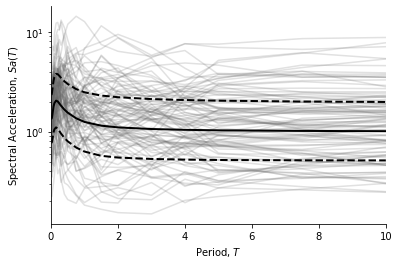

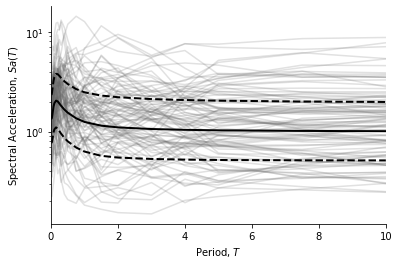

Site: 1, Vs30: 550
Site: 1, Vs30: 550


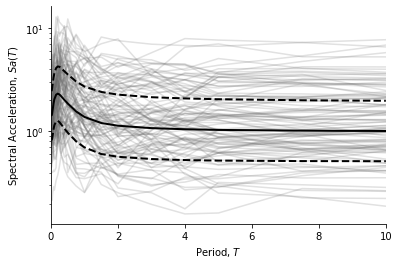

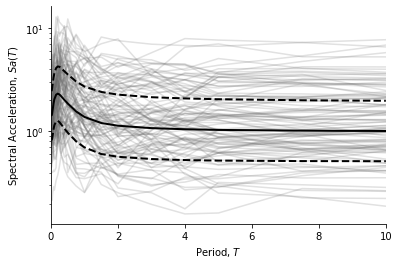

Site: 2, Vs30: 800
Site: 2, Vs30: 800


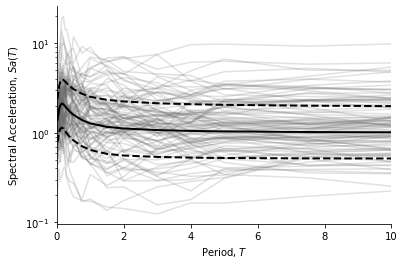

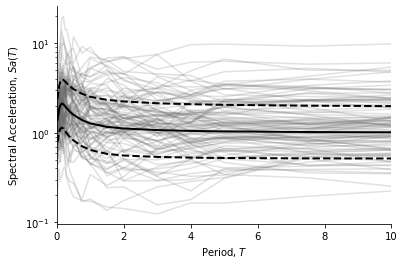

Site: 3, Vs30: 800
Site: 3, Vs30: 800


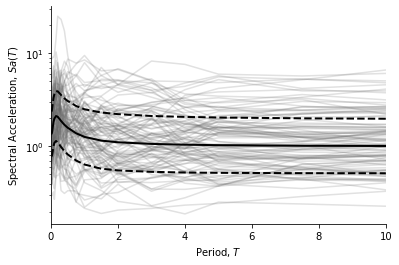

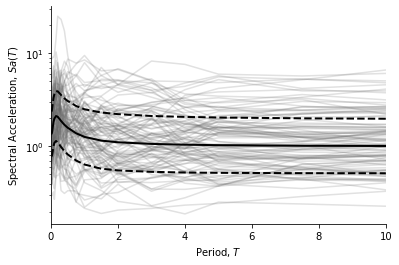

Site: 4, Vs30: 550
Site: 4, Vs30: 550


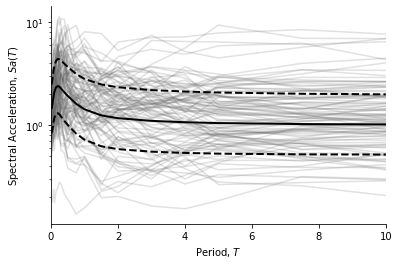

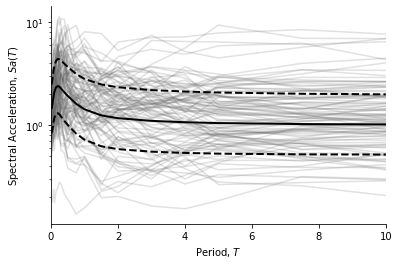

Site: 5, Vs30: 800
Site: 5, Vs30: 800


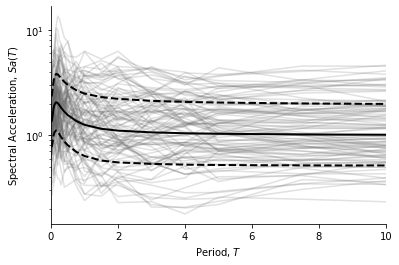

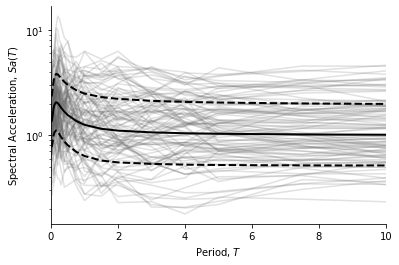

Site: 6, Vs30: 180
Site: 6, Vs30: 180


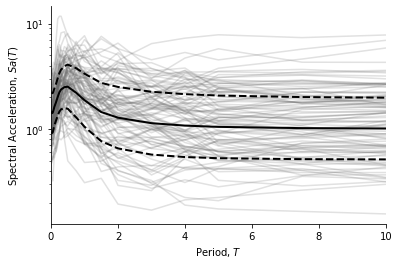

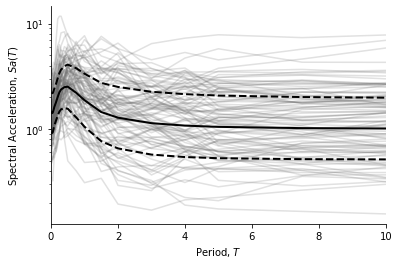

Site: 7, Vs30: 180
Site: 7, Vs30: 180


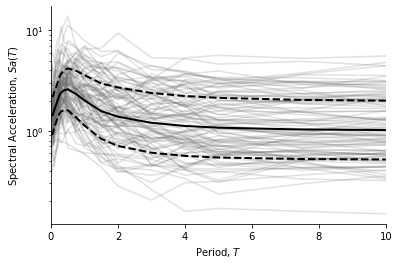

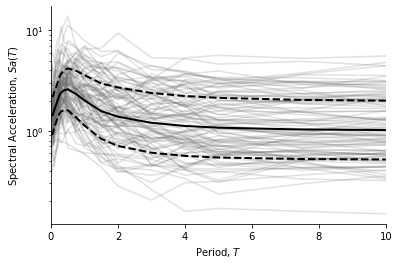

Site: 8, Vs30: 180
Site: 8, Vs30: 180


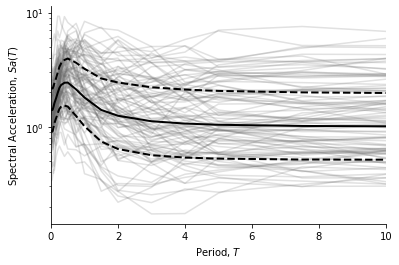

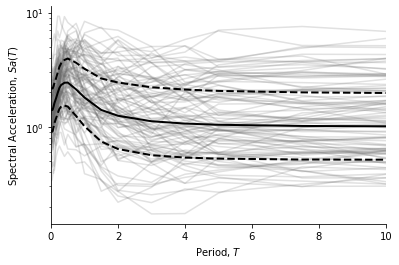

Site: 9, Vs30: 180
Site: 9, Vs30: 180


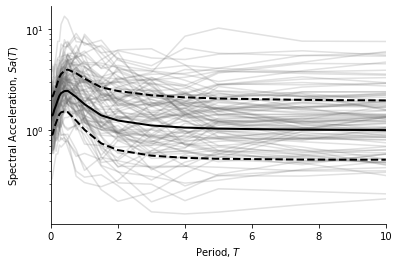

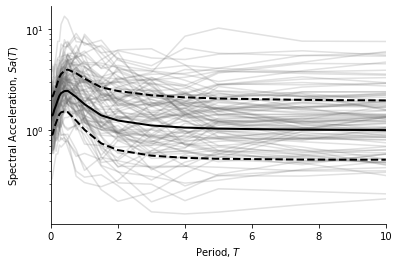

Site: 10, Vs30: 275
Site: 10, Vs30: 275


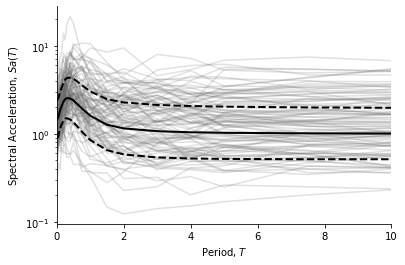

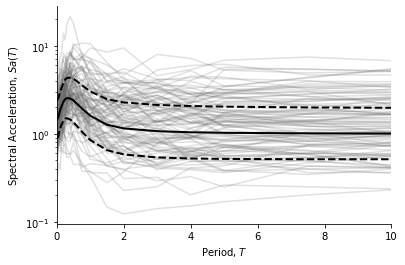

Site: 11, Vs30: 275
Site: 11, Vs30: 275


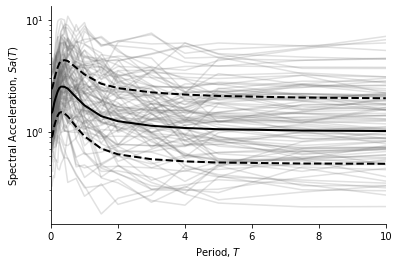

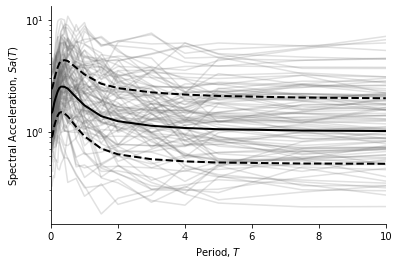

Site: 12, Vs30: 275
Site: 12, Vs30: 275


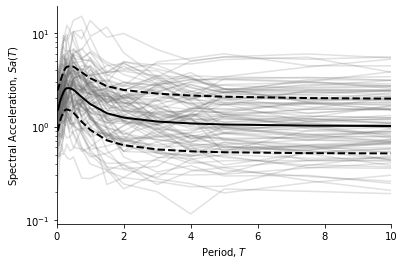

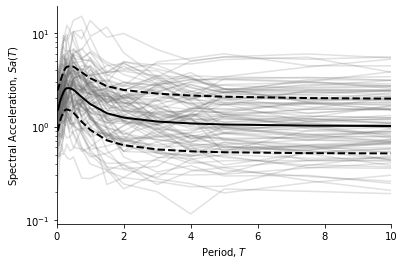

Site: 13, Vs30: 275
Site: 13, Vs30: 275


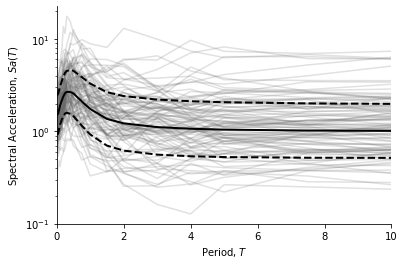

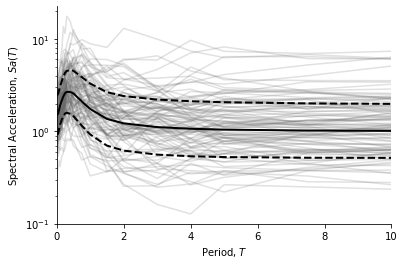

Site: 14, Vs30: 275
Site: 14, Vs30: 275


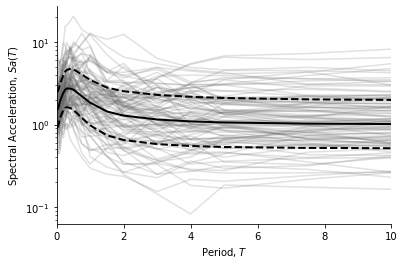

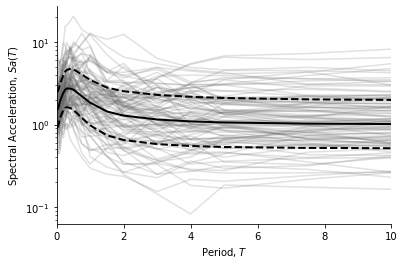

Site: 15, Vs30: 275
Site: 15, Vs30: 275


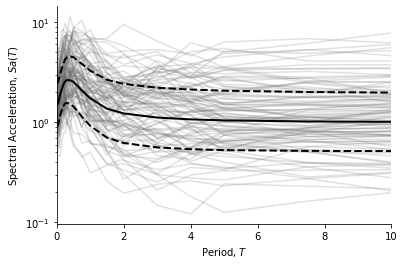

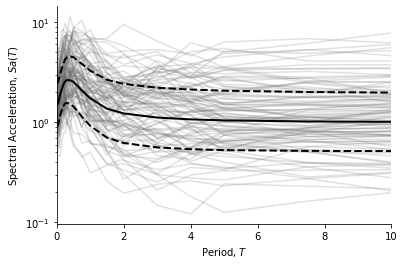

San Andreas Mw7.2
Site: 0, Vs30: 800
San Andreas Mw7.2
Site: 0, Vs30: 800


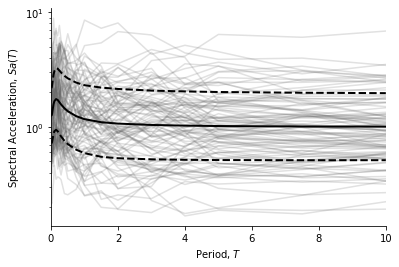

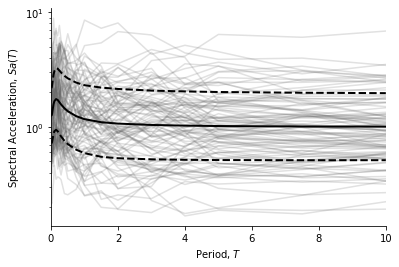

Site: 1, Vs30: 550
Site: 1, Vs30: 550


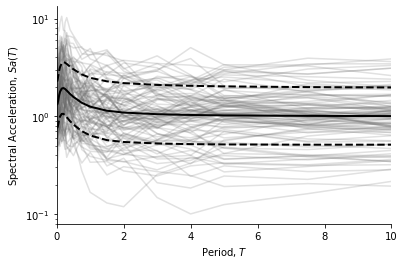

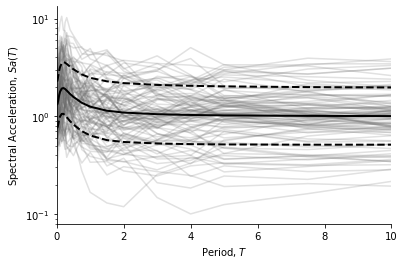

Site: 2, Vs30: 800
Site: 2, Vs30: 800


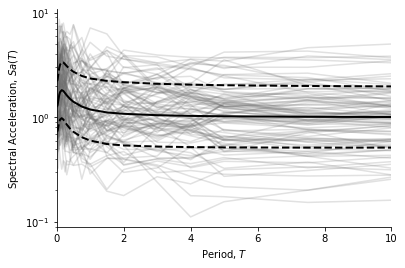

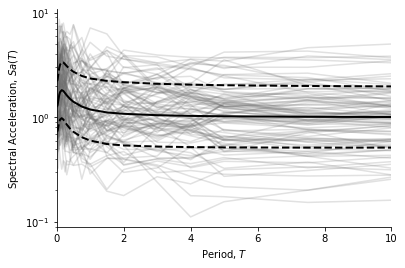

Site: 3, Vs30: 800
Site: 3, Vs30: 800


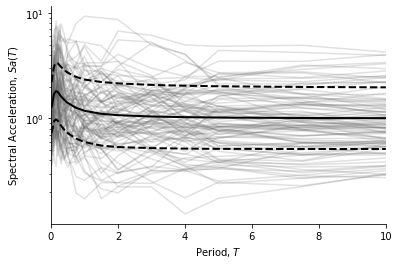

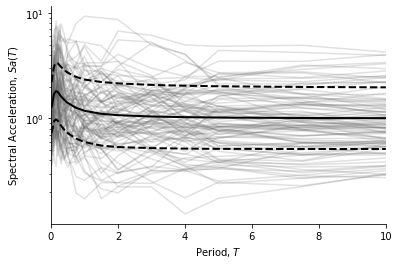

Site: 4, Vs30: 550
Site: 4, Vs30: 550


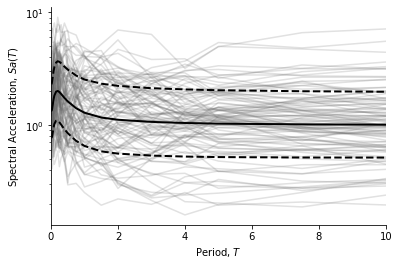

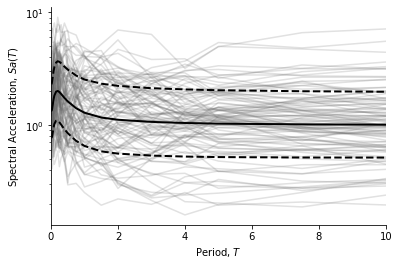

Site: 5, Vs30: 800
Site: 5, Vs30: 800


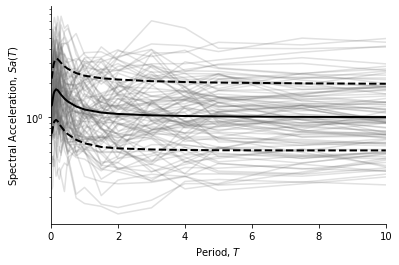

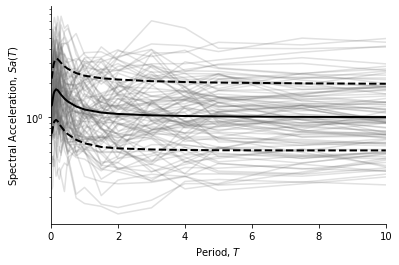

Site: 6, Vs30: 180
Site: 6, Vs30: 180


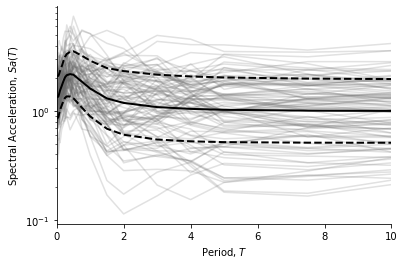

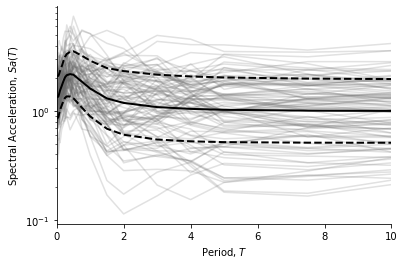

Site: 7, Vs30: 180
Site: 7, Vs30: 180


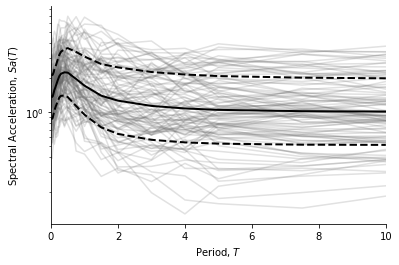

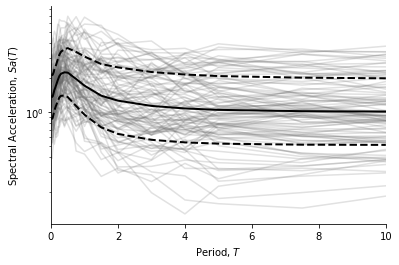

Site: 8, Vs30: 180
Site: 8, Vs30: 180


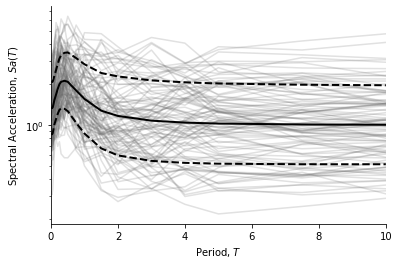

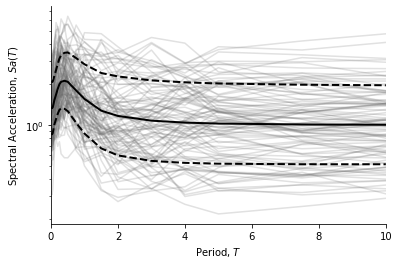

Site: 9, Vs30: 180
Site: 9, Vs30: 180


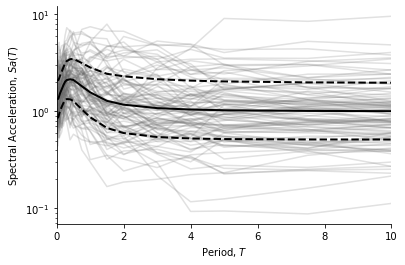

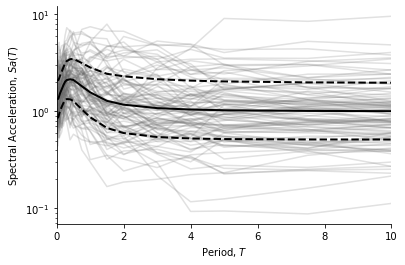

Site: 10, Vs30: 275
Site: 10, Vs30: 275


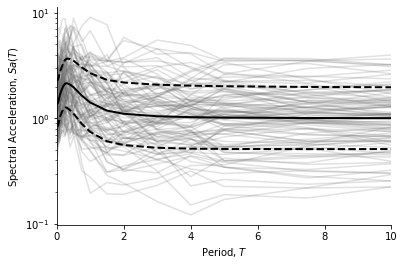

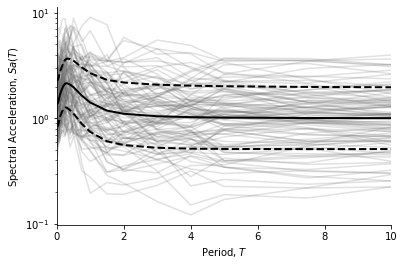

Site: 11, Vs30: 275
Site: 11, Vs30: 275


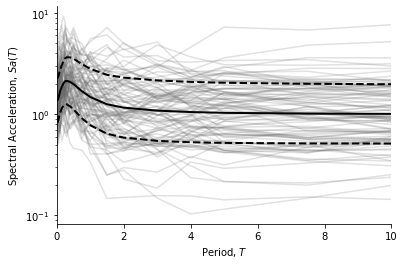

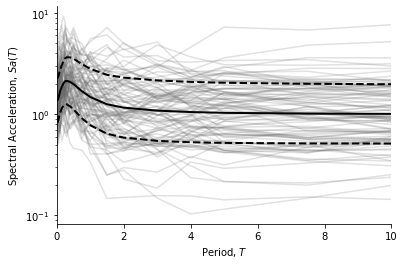

Site: 12, Vs30: 275
Site: 12, Vs30: 275


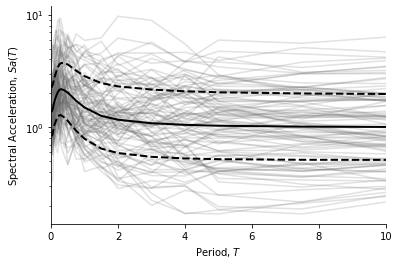

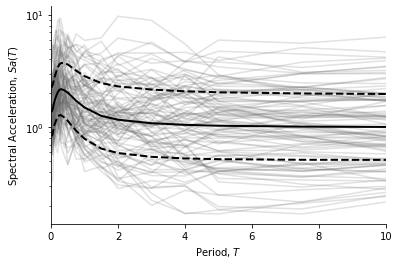

Site: 13, Vs30: 275
Site: 13, Vs30: 275


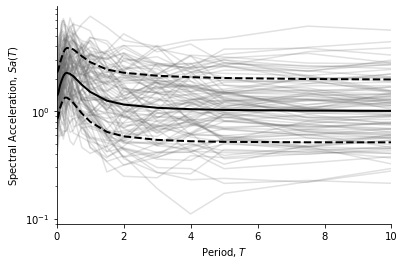

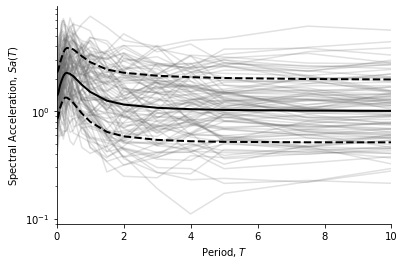

Site: 14, Vs30: 275
Site: 14, Vs30: 275


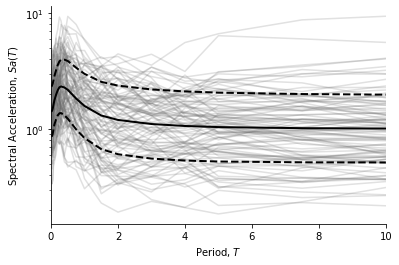

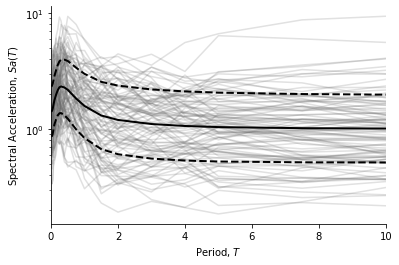

Site: 15, Vs30: 275
Site: 15, Vs30: 275


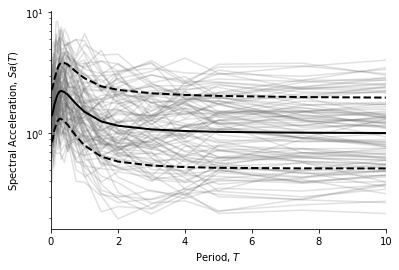

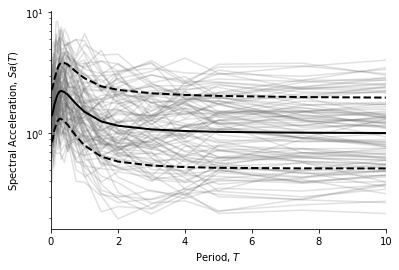

San Andreas Mw6.5
Site: 0, Vs30: 800
San Andreas Mw6.5
Site: 0, Vs30: 800


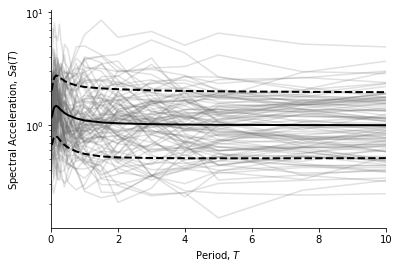

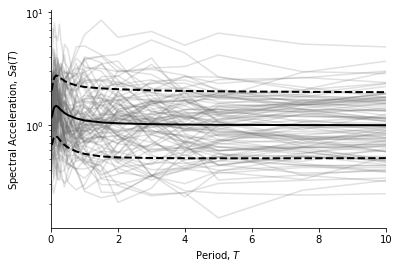

Site: 1, Vs30: 550
Site: 1, Vs30: 550


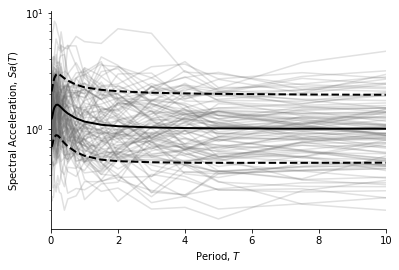

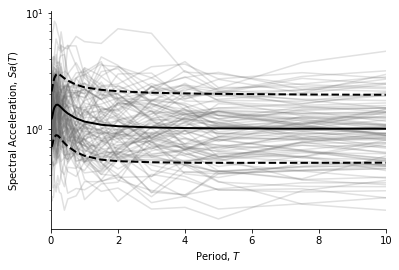

Site: 2, Vs30: 800
Site: 2, Vs30: 800


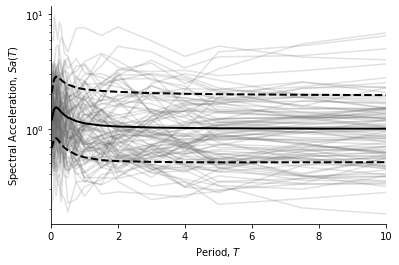

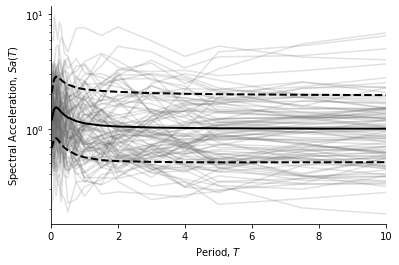

Site: 3, Vs30: 800
Site: 3, Vs30: 800


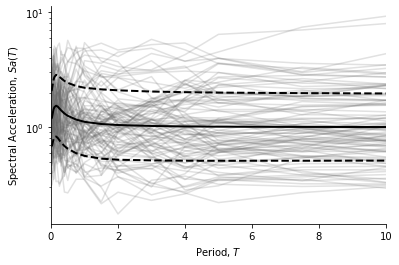

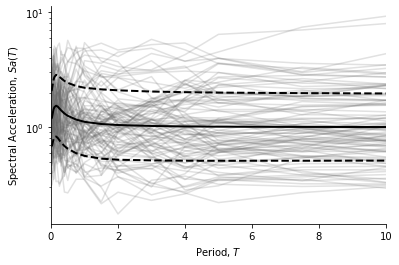

Site: 4, Vs30: 550
Site: 4, Vs30: 550


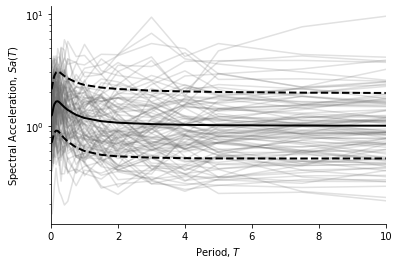

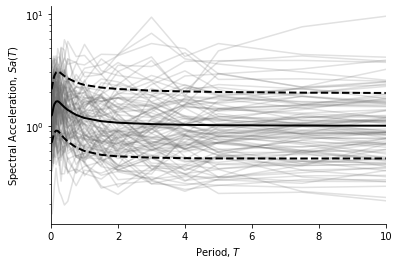

Site: 5, Vs30: 800
Site: 5, Vs30: 800


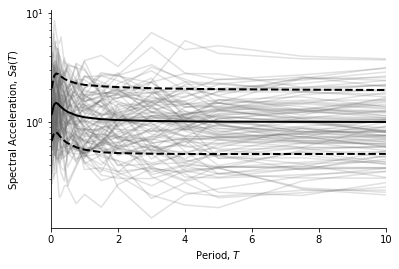

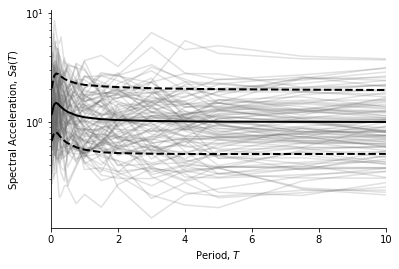

Site: 6, Vs30: 180
Site: 6, Vs30: 180


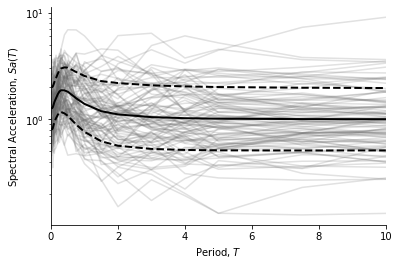

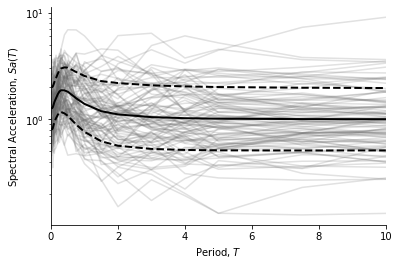

Site: 7, Vs30: 180
Site: 7, Vs30: 180


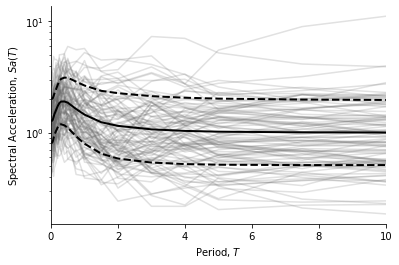

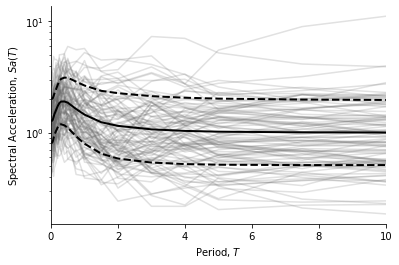

Site: 8, Vs30: 180
Site: 8, Vs30: 180


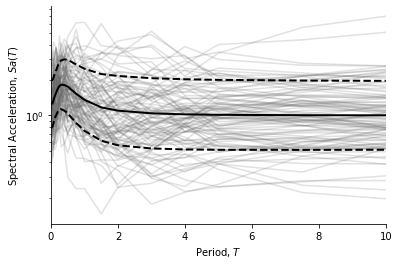

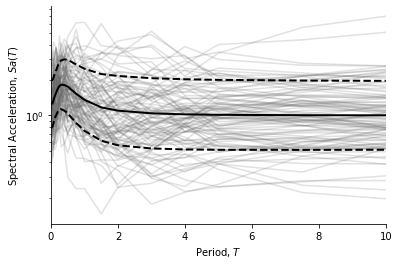

Site: 9, Vs30: 180
Site: 9, Vs30: 180


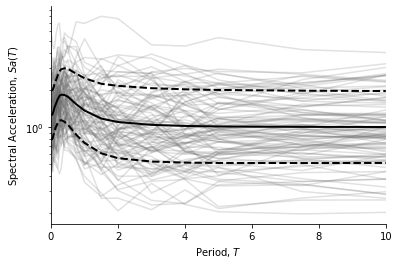

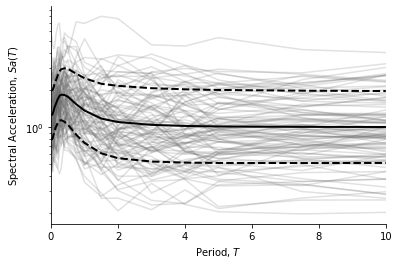

Site: 10, Vs30: 275
Site: 10, Vs30: 275


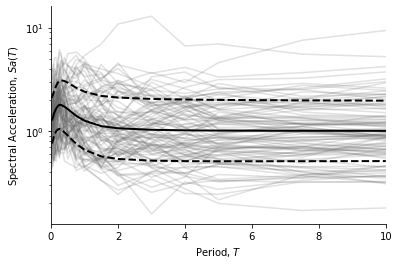

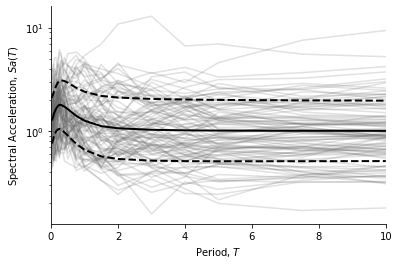

Site: 11, Vs30: 275
Site: 11, Vs30: 275


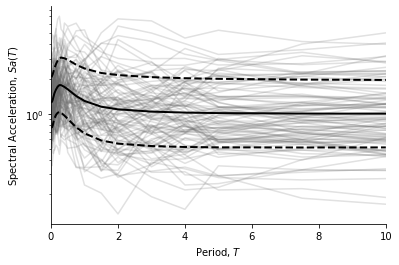

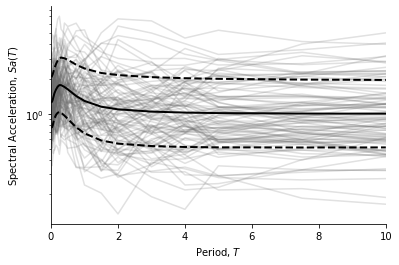

Site: 12, Vs30: 275
Site: 12, Vs30: 275


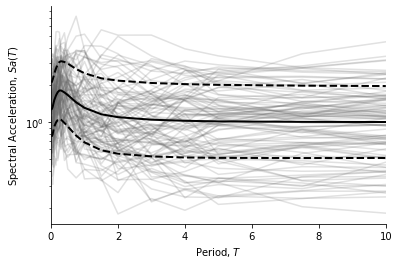

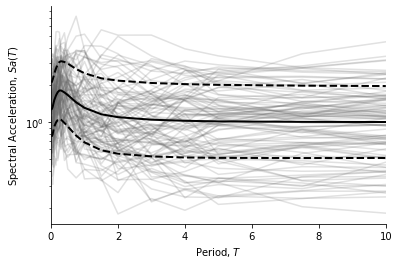

Site: 13, Vs30: 275
Site: 13, Vs30: 275


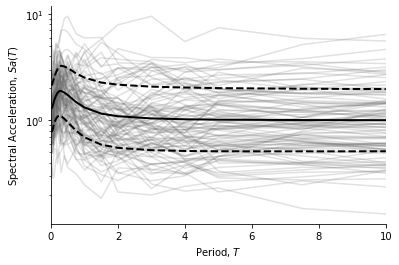

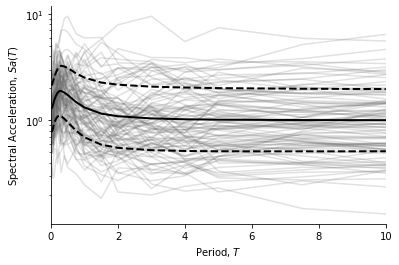

Site: 14, Vs30: 275
Site: 14, Vs30: 275


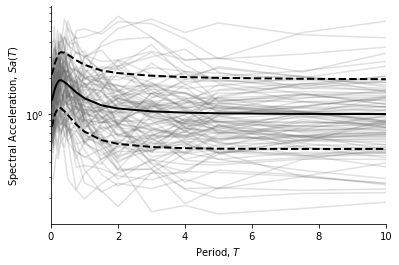

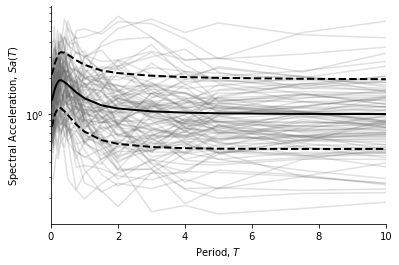

Site: 15, Vs30: 275
Site: 15, Vs30: 275


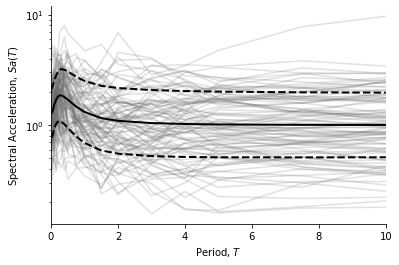

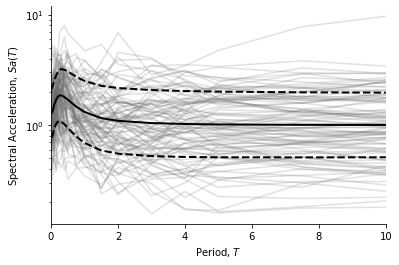

Hayward Mw6.9
Site: 0, Vs30: 800
Hayward Mw6.9
Site: 0, Vs30: 800


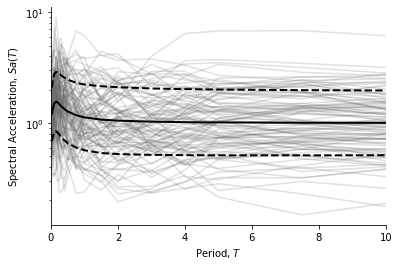

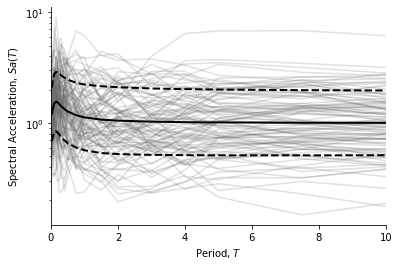

Site: 1, Vs30: 550
Site: 1, Vs30: 550


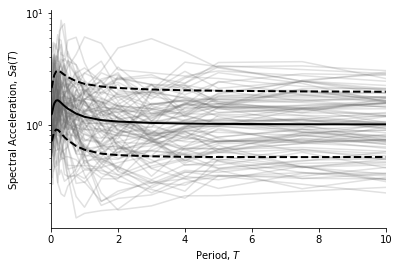

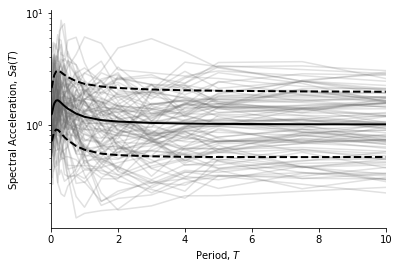

Site: 2, Vs30: 800
Site: 2, Vs30: 800


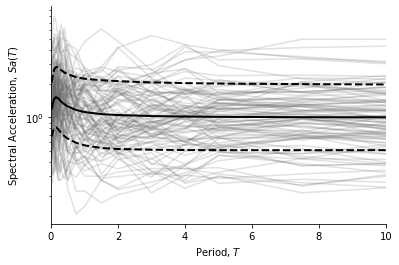

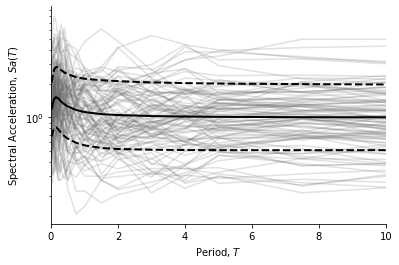

Site: 3, Vs30: 800
Site: 3, Vs30: 800


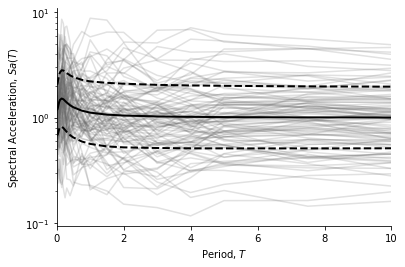

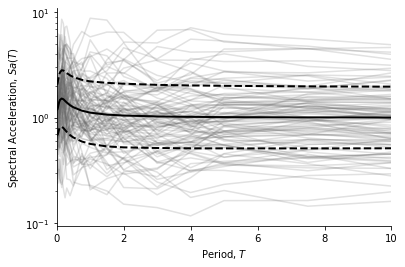

Site: 4, Vs30: 550
Site: 4, Vs30: 550


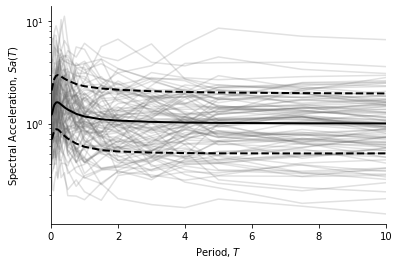

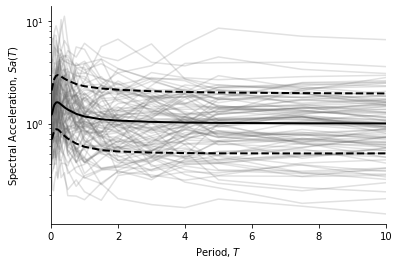

In [ ]:
# plot the first n simulations
n_sims = 100

for i_rup, scenario in enumerate(scenarios):
    print(scenario)
    for i_site in range(n_sites):
        print('Site: '+str(i_site)+', Vs30: '+'{0:.0f}'.format(sites.loc[i_site,'Vs30']))
        fig,ax = plt.subplots(1,1)
        _ = plt.plot(periods, np.exp(medians[i_rup,i_site,:]), color='k', linewidth=2)
        for a in [1,-1]:
            _ = plt.plot(periods, np.exp(medians[i_rup,i_site,:]+a*total_std[i_rup,i_site,:]), color='k', linestyle='--', linewidth=2)
        for i_real in range(n_sims):
            _ = plt.plot(periods, ground_motions[i_rup,i_site,:, i_real], color='dimgray', alpha=0.2, zorder=-1)
        _ = plt.xlabel('Period, $T$')
        _ = plt.xlim([0, max(periods)])
        _ = plt.ylabel('Spectral Acceleration, $Sa(T)$')
        
        if False:
            _ = plt.ylim(bottom=0)
        else:
            _ = plt.yscale('log')
            
        _ = ax.spines['top'].set_visible(False)
        _ = ax.spines['right'].set_visible(False)
        _ = plt.show()